In [1]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

import os
import tensorflow as tf
import tensorflow.keras as keras
from tensorflow.keras import backend as K
from tensorflow.keras import layers

import io

In [2]:
os.environ["CUDA_VISIBLE_DEVICES"]="0"

In [3]:
# Ground truth: volumes generated in numpy
volumes_path = '../data/volumes/volumes_300_15_648_486_1.npy'

# Input: 2D simulated projection created by PSF
sims_path = '../data/sims/sims_300_15_648_486_1.npy'


# Parameters

In [4]:
z_slices = 15

# Downsampling x, y
ds_ratio = 2

# Magnitude scaling
# m = 1e3

# Layers

In [5]:
# Batchnorm epsilon
BN_EPS = 1e-4

class ConvBnRelu2d(layers.Layer):
    def __init__(self, out_channels, kernel_size=(3, 3), padding='same'):
        super(ConvBnRelu2d, self).__init__()
        self.conv = layers.Conv2D(filters=out_channels, kernel_size=kernel_size, padding='same', use_bias=False)
        self.bn = layers.BatchNormalization(epsilon=BN_EPS)
        self.relu = layers.LeakyReLU()
        
    def call(self, x):
        x = self.conv(x)
        x = self.bn(x)
        x = self.relu(x)
        return x

class StackEncoder(layers.Layer):
    def __init__(self, y_channels, kernel_size=3):
        super(StackEncoder, self).__init__()
        padding = (kernel_size - 1) // 2
        self.encode = keras.Sequential([
            ConvBnRelu2d(y_channels, kernel_size=kernel_size, padding='same'),
            ConvBnRelu2d(y_channels, kernel_size=kernel_size, padding='same')
        ])
        self.max_pool = layers.MaxPool2D(pool_size=2, strides=2)
        
    def call(self, x):
        x = self.encode(x)
        x_small = self.max_pool(x)
        return x, x_small


class StackDecoder(layers.Layer):
    def __init__(self, y_channels, kernel_size=3):
        super(StackDecoder, self).__init__()
        padding = (kernel_size - 1) // 2
        
        self.decode = keras.Sequential([
            ConvBnRelu2d(y_channels, kernel_size=kernel_size, padding='same'),
            ConvBnRelu2d(y_channels, kernel_size=kernel_size, padding='same'),
            ConvBnRelu2d(y_channels, kernel_size=kernel_size, padding='same'),
            ]
        )
        
        
    def call(self, x, down_tensor):
        x = layers.UpSampling2D(size=(2, 2), interpolation='bilinear')(x)
        
        # Calculate cropping for down_tensor to concatenate with x
        _, h2, w2, _ = down_tensor.shape
        _, h1, w1, _ = x.shape
        h_diff, w_diff = h2 - h1, w2 - w1
        
        cropping = ((int(np.ceil(h_diff / 2)), int(np.floor(h_diff / 2))),
                    (int(np.ceil(w_diff / 2)), int(np.floor(w_diff / 2))))
        down_tensor = layers.Cropping2D(cropping=cropping)(down_tensor)        
        x = layers.concatenate([x, down_tensor], axis=3)
        x = self.decode(x)
        return x

# Model

In [6]:
class UNet_3d(keras.Model):
    def __init__(self):
        super(UNet_3d, self).__init__()

        self.down1 = StackEncoder(24, kernel_size=3)
        self.down2 = StackEncoder(64, kernel_size=3)
        self.down3 = StackEncoder(128, kernel_size=3)
        self.down4 = StackEncoder(256, kernel_size=3)
        self.down5 = StackEncoder(512, kernel_size=3)
        

        self.up5 = StackDecoder(256, kernel_size=3)
        self.up4 = StackDecoder(128, kernel_size=3)
        self.up3 = StackDecoder(64, kernel_size=3)
        self.up2 = StackDecoder(24, kernel_size=3)
        self.up1 = StackDecoder(24, kernel_size=3)
        self.classify = layers.Conv2D(filters=z_slices, kernel_size=1, use_bias=True)
        
        self.center = ConvBnRelu2d(512, kernel_size=3, padding='same')
        
        
    def call(self, x):
        out = x; 
        down1_tensor, out = self.down1(out); 
        down2_tensor, out = self.down2(out); 
        down3_tensor, out = self.down3(out); 
        down4_tensor, out = self.down4(out); 
        down5_tensor, out = self.down5(out); 

        out = self.center(out)
        
        out = self.up5(out, down5_tensor);
        out = self.up4(out, down4_tensor); 
        out = self.up3(out, down3_tensor); 
        out = self.up2(out, down2_tensor); 
        out = self.up1(out, down1_tensor); 

        out = self.classify(out); 
        return out

# Data Loading, Preprocessing

In [7]:
# Calculate and crop volumes to the smaller target volume shape
def crop(model, sims, volumes):
    _, y, x, _ = volumes.shape
    _, y_target, x_target, _ = model.predict(sims[0][np.newaxis]).shape
    y_diff, x_diff = y - y_target, x - x_target
    
    y_lower = int(np.ceil(y_diff / 2))
    y_upper = y - (y_diff - y_lower)
    x_lower = int(np.ceil(x_diff / 2))
    x_upper = x - (x_diff - x_lower)
    return volumes[:, y_lower:y_upper, x_lower:x_upper]

# Standard normalization by sample
def normalize(x, eps):
    return (x - np.mean(x, axis=0)) / (np.std(x, axis=0) + eps)

In [8]:
model = UNet_3d()

In [9]:
# Load in forward model simulations
sims = np.load(sims_path)
sims = sims[..., np.newaxis] # Expand to channel dimension
sims = sims.astype(np.float32) # Cast to float32
input_shape = sims.shape

# Normalize sims for magnitudes scaling from 0 to m
# sims = (sims - np.min(sims)) / (np.max(sims) - np.min(sims))

In [10]:
# Load in ground truth
volumes = np.load(volumes_path)

volumes = volumes.transpose(0, 2, 3, 1) # Reshape from (n, c, y, x) to (n, y, x, c)
volumes = crop(model, sims, volumes) # Crop to target volume size
# volumes = np.array(volumes)*m # Scale magnitude by m

In [11]:
# Standard normalize input/ground truth
eps = 1e-4
sims = normalize(sims, eps)
volumes = normalize(volumes, eps)

In [12]:
# assert volumes.min() == 0.0 and volumes.max() == m, "volumes min/max scaling issue"
# assert sims.min() == 0.0 and sims.max() == m, "sims min/max scaling issue"

# Visualizations

In [29]:
# Visualizes ground truth
def visualize_volume(volumes, i):
    volume = volumes[i]
    y, x, z = np.nonzero(volume > 1)
    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')
#             sc = ax.scatter(x, z, y, zdir='z', c=volume[z, y, x], cmap='binary')
    sc = ax.scatter(x, z, y, zdir='z', c=volume[y, x, z])
    
    ax.set_xlim(0, volume.shape[1])
    ax.set_zlim(0, volume.shape[0])
    ax.set_ylim(0, volume.shape[2])
    
    plt.colorbar(sc)
    plt.title("Volume #" + str(i))

    plt.show()
    
def plot_to_image(figure):
    """Converts the matplotlib plot specified by 'figure' to a PNG image and
    returns it. The supplied figure is closed and inaccessible after this call."""
    # Save the plot to a PNG in memory.
    buf = io.BytesIO()
    plt.savefig(buf, format='png')
    # Closing the figure prevents it from being displayed directly inside
    # the notebook.
    plt.close(figure)
    buf.seek(0)
    # Convert PNG buffer to TF image
    image = tf.image.decode_png(buf.getvalue(), channels=4)
    # Add the batch dimension
    image = tf.expand_dims(image, 0)
    return image

def proj(v):
    return np.sum(v, axis=-1)

def scaled_mse_loss(y_actual,y_pred):
    loss = K.square((y_actual-y_pred))
#     loss = K.sqrt(loss)
    loss = K.sum(loss)
    return loss

def plot_image_tensorboard(epoch, logs):
    # Create a plot to visualize image reconstruction progress
    i = 3
    # Call the model to get prediction
    pred = model.predict(sims[i][None])

    # Create a mpl figure
    figure = plt.figure(figsize=(10,10))

    # Plot the prediction
    plt.subplot(1, 2, 1)
    plt.title("prediction")
    plt.imshow(proj(pred[0]))
    # Plot groundtruth
    plt.subplot(1, 2, 2)
    plt.title("ground truth")
    plt.imshow(proj(volumes[i]))
    plot_image = plot_to_image(figure)
    with file_writer.as_default():
        tf.summary.image("Prediction vs Ground Truth", plot_image, step=epoch)

import datetime
log_dir=os.path.join('logs', 'fit') + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1, profile_batch=1000000)
file_writer = tf.summary.create_file_writer(log_dir)

plot_image_tensorboard_cb = keras.callbacks.LambdaCallback(on_epoch_end=plot_image_tensorboard)

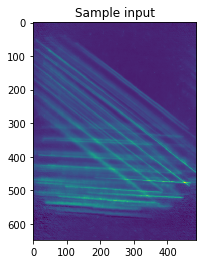

In [30]:
i = 0
plt.title("Sample input")
plt.imshow(sims[i,:,:,0])
plt.show()

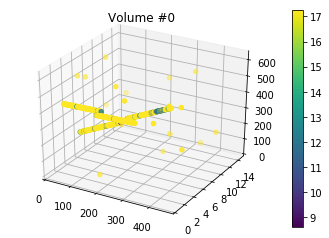

In [31]:
visualize_volume(volumes, i)

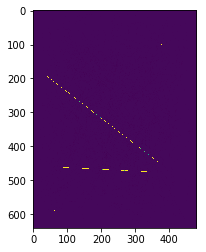

In [32]:
# Visualize projection onto xy-plane
plt.imshow(proj(volumes[i]))

# Training

In [33]:
def scaled_mae_loss(y_actual,y_pred):
    loss = K.abs((y_actual-y_pred))
#     loss = K.sqrt(loss)
    loss = K.sum(loss)
    return loss


In [34]:
adam = tf.keras.optimizers.Adam(learning_rate=1e-3, beta_1=0.9, beta_2=0.999, amsgrad=False)
model.compile(optimizer=adam, loss='mean_squared_error', metrics=['mean_squared_error'])
model.build(input_shape)

In [35]:
model.summary()

Model: "u_net_3d"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
stack_encoder (StackEncoder) multiple                  5592      
_________________________________________________________________
stack_encoder_1 (StackEncode multiple                  51200     
_________________________________________________________________
stack_encoder_2 (StackEncode multiple                  222208    
_________________________________________________________________
stack_encoder_3 (StackEncode multiple                  886784    
_________________________________________________________________
stack_encoder_4 (StackEncode multiple                  3543040   
_________________________________________________________________
stack_decoder (StackDecoder) multiple                  3542016   
_________________________________________________________________
stack_decoder_1 (StackDecode multiple                  886

In [36]:
EPOCHS = 1000
BATCH_SIZE = 8
TRAIN_LENGTH = 200
STEPS_PER_EPOCH = TRAIN_LENGTH // BATCH_SIZE

train_x = sims[:TRAIN_LENGTH]
train_y = volumes[:TRAIN_LENGTH]

model.fit(x=train_x, y=train_y, epochs=EPOCHS, steps_per_epoch=STEPS_PER_EPOCH, callbacks=[plot_image_tensorboard_cb, 
                                                                                           tensorboard_callback])

Train on 200 samples
Epoch 1/1000
200/200 [==============================] - 17s 84ms/sample - loss: 0.0406 - mean_squared_error: 0.0406
Epoch 2/1000
200/200 [==============================] - 13s 64ms/sample - loss: 0.0382 - mean_squared_error: 0.0382
Epoch 3/1000
200/200 [==============================] - 13s 64ms/sample - loss: 0.0381 - mean_squared_error: 0.0381
Epoch 4/1000
200/200 [==============================] - 13s 65ms/sample - loss: 0.0381 - mean_squared_error: 0.0381
Epoch 5/1000
200/200 [==============================] - 13s 65ms/sample - loss: 0.0380 - mean_squared_error: 0.0380
Epoch 6/1000
200/200 [==============================] - 13s 65ms/sample - loss: 0.0380 - mean_squared_error: 0.0380
Epoch 7/1000
200/200 [==============================] - 13s 66ms/sample - loss: 0.0380 - mean_squared_error: 0.0380
Epoch 8/1000
200/200 [==============================] - 13s 65ms/sample - loss: 0.0380 - mean_squared_error: 0.0380
Epoch 9/1000
200/200 [=============================

200/200 [==============================] - 13s 65ms/sample - loss: 0.0376 - mean_squared_error: 0.0376
Epoch 140/1000
200/200 [==============================] - 13s 65ms/sample - loss: 0.0375 - mean_squared_error: 0.0375
Epoch 141/1000
200/200 [==============================] - 13s 65ms/sample - loss: 0.0376 - mean_squared_error: 0.0376
Epoch 142/1000
200/200 [==============================] - 13s 65ms/sample - loss: 0.0375 - mean_squared_error: 0.0375
Epoch 143/1000
200/200 [==============================] - 13s 65ms/sample - loss: 0.0374 - mean_squared_error: 0.0374
Epoch 144/1000
200/200 [==============================] - 13s 65ms/sample - loss: 0.0375 - mean_squared_error: 0.0375
Epoch 145/1000
200/200 [==============================] - 13s 66ms/sample - loss: 0.0375 - mean_squared_error: 0.0375
Epoch 146/1000
200/200 [==============================] - 13s 65ms/sample - loss: 0.0374 - mean_squared_error: 0.0374
Epoch 147/1000
200/200 [==============================] - 13s 65ms/samp

200/200 [==============================] - 13s 65ms/sample - loss: 0.0319 - mean_squared_error: 0.0319
Epoch 278/1000
200/200 [==============================] - 13s 65ms/sample - loss: 0.0324 - mean_squared_error: 0.0324
Epoch 279/1000
200/200 [==============================] - 13s 65ms/sample - loss: 0.0318 - mean_squared_error: 0.0318
Epoch 280/1000
200/200 [==============================] - 13s 66ms/sample - loss: 0.0320 - mean_squared_error: 0.0320
Epoch 281/1000
200/200 [==============================] - 13s 65ms/sample - loss: 0.0317 - mean_squared_error: 0.0317
Epoch 282/1000
200/200 [==============================] - 13s 65ms/sample - loss: 0.0318 - mean_squared_error: 0.0318
Epoch 283/1000
200/200 [==============================] - 13s 65ms/sample - loss: 0.0318 - mean_squared_error: 0.0318
Epoch 284/1000
200/200 [==============================] - 13s 65ms/sample - loss: 0.0311 - mean_squared_error: 0.0311
Epoch 285/1000
200/200 [==============================] - 13s 65ms/samp

200/200 [==============================] - 13s 66ms/sample - loss: 0.0214 - mean_squared_error: 0.0214
Epoch 416/1000
200/200 [==============================] - 13s 65ms/sample - loss: 0.0210 - mean_squared_error: 0.0210
Epoch 417/1000
200/200 [==============================] - 13s 65ms/sample - loss: 0.0212 - mean_squared_error: 0.0212
Epoch 418/1000
200/200 [==============================] - 13s 65ms/sample - loss: 0.0233 - mean_squared_error: 0.0233
Epoch 419/1000
200/200 [==============================] - 13s 65ms/sample - loss: 0.0223 - mean_squared_error: 0.0223
Epoch 420/1000
200/200 [==============================] - 13s 65ms/sample - loss: 0.0219 - mean_squared_error: 0.0219
Epoch 421/1000
200/200 [==============================] - 13s 65ms/sample - loss: 0.0213 - mean_squared_error: 0.0213
Epoch 422/1000
200/200 [==============================] - 13s 65ms/sample - loss: 0.0217 - mean_squared_error: 0.0217
Epoch 423/1000
200/200 [==============================] - 13s 65ms/samp

200/200 [==============================] - 13s 65ms/sample - loss: 0.0170 - mean_squared_error: 0.0170
Epoch 554/1000
200/200 [==============================] - 13s 65ms/sample - loss: 0.0173 - mean_squared_error: 0.0173
Epoch 555/1000
200/200 [==============================] - 13s 65ms/sample - loss: 0.0173 - mean_squared_error: 0.0173
Epoch 556/1000
200/200 [==============================] - 13s 65ms/sample - loss: 0.0172 - mean_squared_error: 0.0172
Epoch 557/1000
200/200 [==============================] - 13s 65ms/sample - loss: 0.0172 - mean_squared_error: 0.0172
Epoch 558/1000
200/200 [==============================] - 13s 65ms/sample - loss: 0.0166 - mean_squared_error: 0.0166
Epoch 559/1000
200/200 [==============================] - 13s 65ms/sample - loss: 0.0161 - mean_squared_error: 0.0161
Epoch 560/1000
200/200 [==============================] - 13s 65ms/sample - loss: 0.0167 - mean_squared_error: 0.0167
Epoch 561/1000
200/200 [==============================] - 13s 65ms/samp

200/200 [==============================] - 13s 65ms/sample - loss: 0.0157 - mean_squared_error: 0.0157
Epoch 692/1000
200/200 [==============================] - 13s 65ms/sample - loss: 0.0141 - mean_squared_error: 0.0141
Epoch 693/1000
200/200 [==============================] - 13s 66ms/sample - loss: 0.0145 - mean_squared_error: 0.0145
Epoch 694/1000
200/200 [==============================] - 13s 66ms/sample - loss: 0.0141 - mean_squared_error: 0.0141
Epoch 695/1000
200/200 [==============================] - 13s 65ms/sample - loss: 0.0142 - mean_squared_error: 0.0142
Epoch 696/1000
200/200 [==============================] - 13s 65ms/sample - loss: 0.0143 - mean_squared_error: 0.0143
Epoch 697/1000
200/200 [==============================] - 13s 65ms/sample - loss: 0.0136 - mean_squared_error: 0.0136
Epoch 698/1000
200/200 [==============================] - 13s 65ms/sample - loss: 0.0133 - mean_squared_error: 0.0133
Epoch 699/1000
200/200 [==============================] - 13s 65ms/samp

200/200 [==============================] - 13s 65ms/sample - loss: 0.0136 - mean_squared_error: 0.0136
Epoch 830/1000
200/200 [==============================] - 13s 65ms/sample - loss: 0.0133 - mean_squared_error: 0.0133
Epoch 831/1000
200/200 [==============================] - 13s 65ms/sample - loss: 0.0134 - mean_squared_error: 0.0134
Epoch 832/1000
200/200 [==============================] - 13s 65ms/sample - loss: 0.0125 - mean_squared_error: 0.0125
Epoch 833/1000
200/200 [==============================] - 13s 65ms/sample - loss: 0.0123 - mean_squared_error: 0.0123
Epoch 834/1000
200/200 [==============================] - 13s 65ms/sample - loss: 0.0128 - mean_squared_error: 0.0128
Epoch 835/1000
200/200 [==============================] - 13s 65ms/sample - loss: 0.0121 - mean_squared_error: 0.0121
Epoch 836/1000
200/200 [==============================] - 13s 65ms/sample - loss: 0.0122 - mean_squared_error: 0.0122
Epoch 837/1000
200/200 [==============================] - 13s 65ms/samp

200/200 [==============================] - 13s 65ms/sample - loss: 0.0114 - mean_squared_error: 0.0114
Epoch 968/1000
200/200 [==============================] - 13s 65ms/sample - loss: 0.0114 - mean_squared_error: 0.0114
Epoch 969/1000
200/200 [==============================] - 13s 65ms/sample - loss: 0.0111 - mean_squared_error: 0.0111
Epoch 970/1000
200/200 [==============================] - 13s 65ms/sample - loss: 0.0109 - mean_squared_error: 0.0109
Epoch 971/1000
200/200 [==============================] - 13s 65ms/sample - loss: 0.0113 - mean_squared_error: 0.0113
Epoch 972/1000
200/200 [==============================] - 13s 65ms/sample - loss: 0.0120 - mean_squared_error: 0.0120
Epoch 973/1000
200/200 [==============================] - 13s 65ms/sample - loss: 0.0125 - mean_squared_error: 0.0125
Epoch 974/1000
200/200 [==============================] - 13s 65ms/sample - loss: 0.0119 - mean_squared_error: 0.0119
Epoch 975/1000
200/200 [==============================] - 13s 65ms/samp

In [78]:
model.save_weights('../models/200_8_1000', save_format='tf')

In [76]:
i = 299

In [68]:
pred = model.predict(sims[i][np.newaxis])

In [72]:
# Visualizes ground truth
def visualize_volume(volumes, i):
    volume = volumes[i]
    y, x, z = np.nonzero(volume > 2)
    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')
#             sc = ax.scatter(x, z, y, zdir='z', c=volume[z, y, x], cmap='binary')
    sc = ax.scatter(x, z, y, zdir='z', c=volume[y, x, z])
    
    ax.set_xlim(0, volume.shape[1])
    ax.set_zlim(0, volume.shape[0])
    ax.set_ylim(0, volume.shape[2])
    
    plt.colorbar(sc)
    plt.title("Volume #" + str(i))

    plt.show()

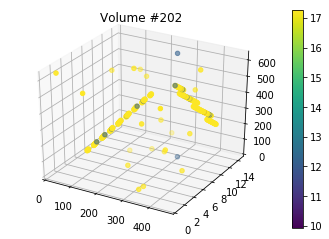

In [73]:
visualize_volume(volumes, i)

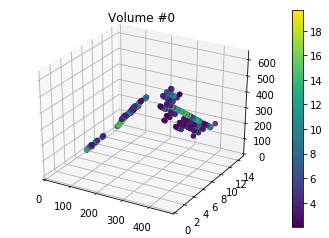

In [74]:
visualize_volume(pred, 0)

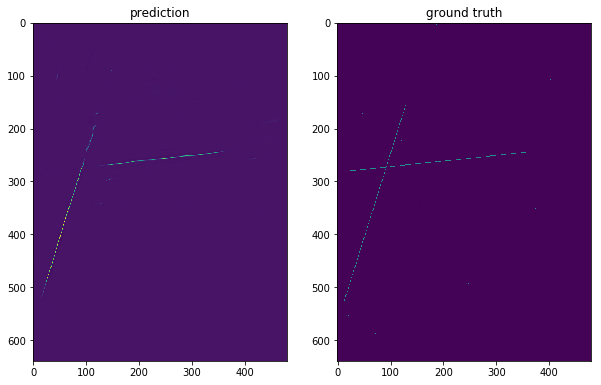

In [77]:
# Call the model to get prediction
pred = model.predict(sims[i][None])

# Create a mpl figure
figure = plt.figure(figsize=(10,10))

# Plot the prediction
plt.subplot(1, 2, 1)
plt.title("prediction")
plt.imshow(proj(pred[0]))
# Plot groundtruth
plt.subplot(1, 2, 2)
plt.title("ground truth")
plt.imshow(proj(volumes[i]))
plt.show()